<a href="https://colab.research.google.com/github/usm1ai/usm1ai/blob/main/Feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/IEEE Access JB/ActLoc10-main


/content/drive/MyDrive/IEEE Access JB/ActLoc10-main


In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import pickle
from scipy.signal import cheby2, filtfilt

In [ ]:
# Import Project  Modules

from Stats import calculate_skewness, calculate_kurtosis
from ED import false_nearest_neighbors
from MLE import estimate_lyapunov_exponent
from MFCC import extract_mfcc
from Stats import calculate_skewness
from Stats import calculate_kurtosis
from FD import calculate_fractal_dimension
from Steps import count_steps
from Step_len import calculate_step_lengths, find_peaks, find_valleys
from Heading import calculate_heading_direction
from GA import genetic_algorithm
from sklearn.model_selection import train_test_split

In [ ]:
acc_wtc = pd.DataFrame(np.load('/content/drive/MyDrive/IEEE Access JB/IEEE Access JB/acc_wtc.npy', allow_pickle=True))
acc_mob = pd.DataFrame(np.load('/content/drive/MyDrive/IEEE Access JB/IEEE Access JB/acc_mob.npy', allow_pickle=True))
gps_wtc = pd.DataFrame(np.load('/content/drive/MyDrive/IEEE Access JB/IEEE Access JB/gps_wtc.npy', allow_pickle=True))
gps_mob = pd.DataFrame(np.load('/content/drive/MyDrive/IEEE Access JB/IEEE Access JB/gps_mob.npy', allow_pickle=True))
ori_wtc = pd.DataFrame(np.load('/content/drive/MyDrive/IEEE Access JB/IEEE Access JB/ori_wtc.npy', allow_pickle=True))
ori_mob = pd.DataFrame(np.load('/content/drive/MyDrive/IEEE Access JB/IEEE Access JB/ori_mob.npy', allow_pickle=True))

acc_wtc = acc_wtc.rename(columns={0: 'acc_x', 1: 'acc_y', 2: 'acc_z', 3: 'location', 4: 'activity'})
acc_mob = acc_mob.rename(columns={0: 'acc_x', 1: 'acc_y', 2: 'acc_z', 3: 'location', 4: 'activity'})
ori_wtc = ori_wtc.rename(columns={0: 'ori_x', 1: 'ori_y', 2: 'ori_z', 3: 'location', 4: 'activity'})
ori_mob = ori_mob.rename(columns={0: 'ori_x', 1: 'ori_y', 2: 'ori_z', 3: 'location', 4: 'activity'})
gps_wtc = gps_wtc.rename(columns={0: 'long', 1: 'lat', 2: 'location', 3: 'activity'})
gps_mob = gps_mob.rename(columns={0: 'long', 1: 'lat', 2: 'location', 3: 'activity'})

In [ ]:
acc_activity_wtc = acc_wtc.drop(['location'], axis=1)
acc_location_wtc = acc_wtc.drop(['activity'], axis=1)
acc_activity_mob = acc_mob.drop(['location'], axis=1)
acc_location_mob = acc_mob.drop(['activity'], axis=1)

ori_activity_wtc = ori_wtc.drop(['location'], axis=1)
ori_location_wtc = ori_wtc.drop(['activity'], axis=1)
ori_activity_mob = ori_mob.drop(['location'], axis=1)
ori_location_mob = ori_mob.drop(['activity'], axis=1)

gps_activity_wtc = gps_wtc.drop(['location'], axis=1)
gps_location_wtc = gps_wtc.drop(['activity'], axis=1)
gps_activity_mob = gps_mob.drop(['location'], axis=1)
gps_location_mob = gps_mob.drop(['activity'], axis=1)

In [ ]:
def pick_samples_activity(data, num_samples_per_class):
  classes = data['activity'].unique()
  sampled_data = pd.DataFrame()
  for class_label in classes:
    class_data = data[data['activity'] == class_label]
    num_samples = min(num_samples_per_class, len(class_data))
    sampled_class_data = class_data.sample(n=num_samples)
    sampled_data = pd.concat([sampled_data, sampled_class_data])
  return sampled_data

sampled_acc_activity_wtc = pick_samples_activity(acc_activity_wtc, 300).reset_index(drop=True)
sampled_acc_activity_mob = pick_samples_activity(acc_activity_mob, 300).reset_index(drop=True)
sampled_ori_activity_wtc = pick_samples_activity(ori_activity_wtc, 300).reset_index(drop=True)
sampled_ori_activity_mob = pick_samples_activity(ori_activity_mob, 300).reset_index(drop=True)
sampled_gps_activity_wtc = pick_samples_activity(gps_activity_wtc, 300).reset_index(drop=True)
sampled_gps_activity_mob = pick_samples_activity(gps_activity_mob, 300).reset_index(drop=True)


In [ ]:
def pick_samples_location(data, num_samples_per_class):
  classes = data['location'].unique()
  sampled_data = pd.DataFrame()
  for class_label in classes:
    class_data = data[data['location'] == class_label]
    num_samples = min(num_samples_per_class, len(class_data))
    sampled_class_data = class_data.sample(n=num_samples)
    sampled_data = pd.concat([sampled_data, sampled_class_data])
  return sampled_data

sampled_acc_location_wtc = pick_samples_location(acc_location_wtc, 300).reset_index(drop=True)
sampled_acc_location_mob = pick_samples_location(acc_location_mob, 300).reset_index(drop=True)
sampled_ori_location_wtc = pick_samples_location(ori_location_wtc, 300).reset_index(drop=True)
sampled_ori_location_mob = pick_samples_location(ori_location_mob, 300).reset_index(drop=True)
sampled_gps_location_wtc = pick_samples_location(gps_location_wtc, 300).reset_index(drop=True)
sampled_gps_location_mob = pick_samples_location(gps_location_mob, 300).reset_index(drop=True)

In [ ]:
acc_activity = pd.concat([sampled_acc_activity_wtc, sampled_acc_activity_mob], ignore_index=True)
acc_location = pd.concat([sampled_acc_location_wtc, sampled_acc_location_mob], ignore_index=True)

ori_activity = pd.concat([sampled_ori_activity_wtc, sampled_ori_activity_mob], ignore_index=True)
ori_location = pd.concat([sampled_ori_location_wtc, sampled_ori_location_mob], ignore_index=True)

gps_activity = pd.concat([sampled_gps_activity_wtc, sampled_gps_activity_mob], ignore_index=True)
gps_location = pd.concat([sampled_gps_location_wtc, sampled_gps_location_mob], ignore_index=True)

In [ ]:
Counter(acc_activity['activity'])

Counter({'Climbing (down)': 600,
         'Climbing (up)': 600,
         'Sitting': 600,
         'Standing': 600,
         'Walking': 600,
         'Recumbency': 600,
         'Jumping': 214,
         'Running': 600})

In [ ]:
walking_samples = acc_activity[acc_activity['activity'] == 'Walking'].reset_index(drop=True)
Sitting_samples = acc_activity[acc_activity['activity'] == 'Sitting'].reset_index(drop=True)
Standing_samples = acc_activity[acc_activity['activity'] == 'Standing'].reset_index(drop=True)
Climbing_up_samples = acc_activity[acc_activity['activity'] == 'Climbing (up)'].reset_index(drop=True)
Recumbency_samples = acc_activity[acc_activity['activity'] == 'Recumbency'].reset_index(drop=True)
Climbing_down_samples = acc_activity[acc_activity['activity'] == 'Climbing (down)'].reset_index(drop=True)
Jumping_samples = acc_activity[acc_activity['activity'] == 'Jumping'].reset_index(drop=True)
Running_samples = acc_activity[acc_activity['activity'] == 'Running'].reset_index(drop=True)

all_activities = [walking_samples, Sitting_samples, Climbing_up_samples, Running_samples]

ValueError: data type <class 'numpy.object_'> not inexact

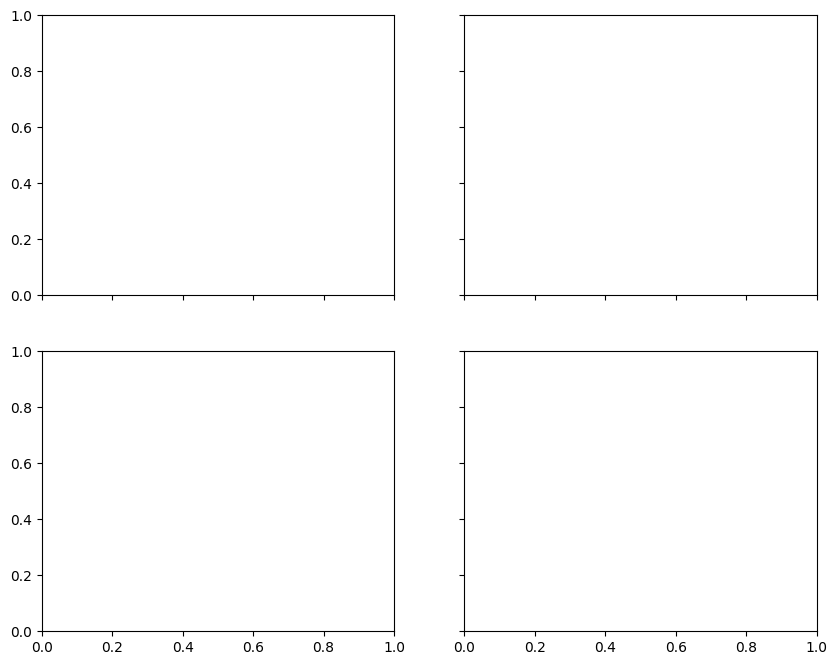

In [ ]:
from scipy.stats import skew, kurtosis
signal_length = 600
num_windows = 4
window_length = 60

order = 4          # Filter order
fs = 500.0         # Sampling frequency (Hz)
fc = 50.0          # Cutoff frequency (Hz)
rp = 5             # Passband ripple (dB)
b, a = cheby2(order, rp, fc, fs=fs, analog=False, output='ba')

win_name = ['Walking', 'Sitting', 'Climbing-Up', 'Running']
colors = ['blue', 'orange', 'brown', 'yellow']
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)

for idx, sig in enumerate(all_activities):
  signal = np.array(sig['acc_z'])
  # Apply Blackman window
  window = np.blackman(60)
  windows = [signal[i:i+window_length] * window for i in range(0, signal_length - window_length + 1, window_length)]
  feat_array=[]
  for win in windows:
      filtered_signal = filtfilt(b, a, win)
      feat = skew(win)
      feat_array.append(feat)

  axes[idx].plot(feat_array, color=colors[idx], alpha=0.6, linewidth=2)
  axes[idx].set_title(win_name[idx])
  axes[idx].grid(True)
  axes[idx].spines['top'].set_visible(False)
  axes[idx].spines['right'].set_visible(False)
  axes[idx].spines['left'].set_visible(False)
  axes[idx].spines['bottom'].set_visible(False)
  axes[idx].set_xlabel('Time (seconds)')
  axes[idx].set_ylabel('Amplitude')
plt.tight_layout()
plt.show()
